# iNeRF

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
import os

ROOT_DIR = os.getcwd()
sys.path.insert(0, os.path.join(ROOT_DIR, "src"))

import json
import util
import torch
import numpy as np
from model import make_model
from render import NeRFRenderer
import torchvision.transforms as T
import tqdm
import imageio
import cv2
import mediapy as media
import matplotlib.pyplot as plt
from PIL import Image

## Config

- `input`: the path of the source image for pixelNeRF.
- `target`: the path of the target whose pose we want to estimate.
- `output`: the directory to save rendered output.

In [3]:
config = {
    'input': './input/1.png',
    'target': './input/2.png',
    'output': './pose_estimation'
}

## Visualize the input data

We show both the source image and the target image. Our goal is to 1) use pixelNeRF to generate a NeRF based on the source image and 2) estimate the relative pose between them.

Source,Target

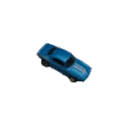
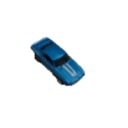

In [4]:
input_image_np = np.array(Image.open(config['input']).convert("RGB"))
target_image_np = np.array(Image.open(config['target']).convert("RGB"))

media.show_images({
    'Source':  input_image_np,
    'Target': target_image_np
})

## PixelNeRF

Load the pixelNeRF. Make sure the `./checkpoints/srn_car/pixel_nerf_latest` exist.

In [6]:
def extra_args(parser):
    parser.add_argument(
        "--input",
        "-I",
        type=str,
        help="Input image to condition on.",
    )
    parser.add_argument(
        "--target",
        "-T",
        type=str,
        help="Target image to estimate the pose.",
    )
    parser.add_argument(
        "--output",
        "-O",
        type=str,
        default=os.path.join(ROOT_DIR, "pose_estimation"),
        help="Output directory",
    )
    parser.add_argument("--size", type=int, default=128, help="Input image maxdim")
    parser.add_argument(
        "--out_size",
        type=str,
        default="128",
        help="Output image size, either 1 or 2 number (w h)",
    )

    parser.add_argument("--focal", type=float, default=131.25, help="Focal length")
    parser.add_argument("--radius", type=float, default=1.3, help="Camera distance")
    parser.add_argument("--z_near", type=float, default=0.8)
    parser.add_argument("--z_far", type=float, default=1.8)
    parser.add_argument(
        "--elevation",
        "-e",
        type=float,
        default=0.0,
        help="Elevation angle (negative is above)",
    )
    parser.add_argument(
        "--num_views",
        type=int,
        default=1,
        help="Number of video frames (rotated views)",
    )
    parser.add_argument("--fps", type=int, default=15, help="FPS of video")
    parser.add_argument("--gif", action="store_true", help="Store gif instead of mp4")
    parser.add_argument(
        "--no_vid",
        action="store_true",
        help="Do not store video (only image frames will be written)",
    )
    parser.add_argument("--lrate", type=float, default=1e-2)
    parser.add_argument("--n_steps", type=int, default=500, help="Number of steps for pose optimization.")
    return parser


args, conf = util.args.parse_args(
    extra_args, default_expname="srn_car", default_data_format="srn", jupyter=True
)
args.resume = True
os.makedirs(args.output, exist_ok=True)

device = util.get_cuda(args.gpu_id[0])

z_near, z_far = args.z_near, args.z_far
focal = torch.tensor(args.focal, dtype=torch.float32, device=device)

in_sz = args.size
sz = list(map(int, args.out_size.split()))
if len(sz) == 1:
    H = W = sz[0]
else:
    assert len(sz) == 2
    W, H = sz
    
net = make_model(conf["model"]).to(device=device).load_weights(args)

# Create the renderer.
renderer = NeRFRenderer.from_conf(
    conf["renderer"], eval_batch_size=args.ray_batch_size
).to(device=device)
render_par = renderer.bind_parallel(net, args.gpu_id, simple_output=True)

EXPERIMENT NAME: srn_car
* Config file: conf/exp/srn.conf
* Dataset format: srn
* Dataset location: data
Using torchvision resnet34 encoder
Load checkpoints/srn_car/pixel_nerf_latest


## iNeRF

In [ ]:
image_to_tensor = util.get_image_to_tensor_balanced()

# Encoding the input image.
print(f"Input image: {config['input']}")
input_image = Image.fromarray(input_image_np)
input_image = T.Resize(in_sz)(input_image)
input_image = image_to_tensor(input_image).to(device=device)
input_pose = torch.eye(4)
input_pose[2, -1] = args.radius

print(f"Target image: {config['target']}")
target_image = Image.fromarray(target_image_np)
target_image = T.Resize(in_sz)(target_image)
target_image_flatten = np.reshape(target_image, [-1, 3]) / 255.0
target_image_flatten = torch.from_numpy(target_image_flatten).float().to(device=device)

cam_pose = torch.clone(input_pose.detach()).unsqueeze(0)
cam_pose.requires_grad = True

print("Input pose:")
print(f"{input_pose}")
print("Init pose:")
print(f"{cam_pose[0]}")

# Create optimizer.
optimizer = torch.optim.Adam(params=[cam_pose], lr=args.lrate)
n_steps = 100 + 1

# Loss.
mse_loss = torch.nn.MSELoss()

# Sampling.
# n_rays = 1024
n_rays = 256
sampling = 'center'

# Pose optimization.
predicted_poses = []
fine_patches = []
gt_patches = []

for i_step in range(n_steps):
    # Encode.
    net.encode(
        input_image.unsqueeze(0), input_pose.unsqueeze(0).to(device=device), focal,
    )

    render_rays = util.gen_rays(cam_pose, W, H, focal, z_near, z_far)
    render_rays_flatten = render_rays.view(-1, 8)
    assert render_rays_flatten.shape[0] == H*W
    if sampling == 'random':
        idxs_sampled = torch.randint(0, H*W, (n_rays,))
    elif sampling == 'center':
        frac = 0.5
        mask = torch.zeros((H, W))
        h_low = int(0.5*(1-frac)*H)
        h_high = int(0.5*(1+frac)*H)
        w_low = int(0.5*(1-frac)*W)
        w_high = int(0.5*(1+frac)*W)
        mask[h_low:h_high, w_low:w_high] = 1
        mask = mask.reshape(H*W)

        idxs_masked = torch.where(mask>0)[0]
        idxs_sampled = idxs_masked[torch.randint(0, idxs_masked.shape[0], (n_rays,))]
    elif sampling == 'patch':
        frac = 0.25
        mask = torch.zeros((H, W))
        h_low = int(0.5*(1-frac)*H)
        h_high = int(0.5*(1+frac)*H)
        w_low = int(0.5*(1-frac)*W)
        w_high = int(0.5*(1+frac)*W)
        mask[h_low:h_high, w_low:w_high] = 1
        mask = mask.reshape(H*W)

        idxs_sampled = torch.where(mask>0)[0]

    render_rays_sampled = render_rays_flatten[idxs_sampled].to(device=device)

    rgb, _ = render_par(render_rays_sampled[None])
    loss = mse_loss(rgb, target_image_flatten[idxs_sampled][None])

    optimizer.zero_grad()
    loss.backward()

    if i_step % 10 == 0:        
        predicted_poses.append(torch.clone(cam_pose[0]).detach().numpy())
        fine_patches.append(torch.clone(rgb[0]).detach().cpu().numpy().reshape(16, 16, 3))
        gt_patches.append(torch.clone(target_image_flatten[idxs_sampled]).detach().cpu().numpy().reshape(16, 16, 3))

#         pose_pred = predicted_poses[-1].copy()
#         pose_pred[2, -1] -= args.radius
#         pose_pred = pose_input @ pose_pred
#         error_R, error_t = compute_pose_error(pose_pred, pose_target)
        print(f"Step {i_step}, loss: {loss}")
        
    optimizer.step()

Input image: ./input/1.png
Target image: ./input/2.png
Input pose:
tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 1.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 1.0000, 1.3000],
        [0.0000, 0.0000, 0.0000, 1.0000]])
Init pose:
tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 1.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 1.0000, 1.3000],
        [0.0000, 0.0000, 0.0000, 1.0000]], grad_fn=<SelectBackward0>)


/home/silvery/anaconda3/envs/monorec/lib/python3.7/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755953518/work/aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Step 0, loss: 0.08876761049032211
Step 10, loss: 0.053155094385147095
Step 20, loss: 0.01851617731153965
Step 30, loss: 0.018893860280513763
Step 40, loss: 0.014758773148059845
Step 50, loss: 0.01035289280116558
Step 60, loss: 0.008575592190027237
Step 70, loss: 0.00871390663087368
Step 80, loss: 0.009569994173943996
Step 90, loss: 0.011951303109526634
Step 100, loss: 0.008705182932317257


## Render the results

In [ ]:
def create_image(patch):
    image = np.zeros((128, 128, 3))
    image[48:80, 48:80, :] = patch
    image = (image * 255.0).astype(np.uint8)
    return image

# Rendering.
overlay_frames = []
n_poses = len(predicted_poses)
render_poses = torch.from_numpy(np.array(predicted_poses))
render_rays = util.gen_rays(render_poses, W, H, focal, z_near, z_far).to(device=device)
with torch.no_grad():
    print("Rendering", n_poses * H * W, "rays")
    all_rgb_fine = []
    for rays in tqdm.tqdm(torch.split(render_rays.view(-1, 8), 80000, dim=0)):
        rgb, _depth = render_par(rays[None])
        all_rgb_fine.append(rgb[0])
    _depth = None
    rgb_fine = torch.cat(all_rgb_fine)
    frames = (rgb_fine.view(n_poses, H, W, 3).cpu().numpy() * 255).astype(
        np.uint8
    )
    target_image = (target_image_flatten.cpu().numpy().reshape([H, W, 3]) * 255.0).astype(np.uint8)
    target_images = np.stack([np.array(target_image)]*n_poses, 0)
    
    im_name = os.path.basename(os.path.splitext(config['input'])[0])

    frames_dir_name = os.path.join(config['output'], im_name + "_frames")
    os.makedirs(frames_dir_name, exist_ok=True)

    for i in range(n_poses):
        if sampling == 'patch':
            pred_patch_path = os.path.join(config['output'], f'./pred_patch_{i}.png')
            pred_image = create_image(fine_patches[i])

            gt_patch_path = os.path.join(config['output'], f'./gt_patch_{i}.png')
            gt_image = create_image(gt_patches[i])
            overlay_frame = (pred_image*0.5).astype(np.uint8) + (gt_image*0.5).astype(np.uint8)
        else:
            overlay_frame = (frames[i]*0.5).astype(np.uint8) + (target_images[i]*0.5).astype(np.uint8)
        overlay_frames.append(overlay_frame)

Rendering 180224 rays


100%|██████████| 3/3 [00:37<00:00, 12.62s/it]


## Visualize the results

We show the overlay of the image rendered with our predicted pose and the target image.

Step 0,Step 10,Step 20,Step 30,Step 40,Step 50,Step 60,Step 70,Step 80,Step 90,Step 100

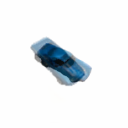
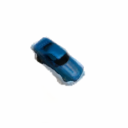
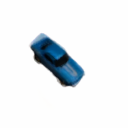
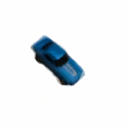
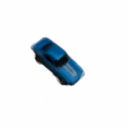
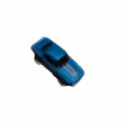
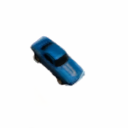
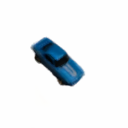
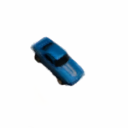
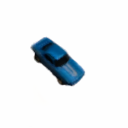
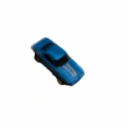

In [ ]:
data = {}
for i, f in enumerate(overlay_frames):
    step = i*10
    data[f"Step {step}"] = f
media.show_images(data)